 # KBC Direct Market Optimization

### Below source code represents classifying customers having high propensity to buy Consumer loans

In [28]:
#############################################################################################
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xlrd

In [29]:
#############################################################################################
# Import excel file from location
file_location = ('Task_Data_Scientist_Dataset.xlsx')
workbook = xlrd.open_workbook(file_location)
print("the number of worksheets are",workbook.nsheets)

the number of worksheets are 5


In [30]:
#############################################################################################
# Load sequentially the spread sheets into subsequent dataframe
spread_sheet = pd.ExcelFile(file_location)
socail_demographic = spread_sheet.parse('Soc_Dem')
products_balance = spread_sheet.parse('Products_ActBalance')
inflow_outflow = spread_sheet.parse('Inflow_Outflow')
sales_revenue = spread_sheet.parse('Sales_Revenues')

In [31]:
#############################################################################################
# Merge the sheets to one major sheet in order to implement the learning model
merge_first_second = pd.merge(socail_demographic, products_balance, how='left', left_on='Client', right_on='Client') 
merge_second_third = pd.merge(inflow_outflow, sales_revenue, how='left', left_on='Client', right_on='Client')
result_merged = pd.merge(merge_first_second, merge_second_third, how='left', left_on='Client', right_on='Client')
result_merged = result_merged.set_index('Client')

na_entries = {'Count_MF': 79, 'Count_CL':5,
              'Count_OVD':2,'Count_CC':2,
              'ActBal_SA':0,'ActBal_MF':0,
              'ActBal_OVD':0, 'Count_SA': 6,
              'ActBal_CC':0,'ActBal_CL':0 }
result_merged = result_merged.fillna(value=na_entries, inplace=False)
result_merged =result_merged .dropna(axis=0, how='any')

In [32]:
#############################################################################################
# Implement LabelEncoder class to convert categorical variables to numerical values
from sklearn import preprocessing
number=preprocessing.LabelEncoder()
result_merged ['Sex']=number.fit_transform(result_merged ['Sex'].astype('str'))

# Assign a variable used for prediction by removing Sale_CL, the target variable
prediction_features = result_merged.drop('Sale_CL', axis=1)

# Assign explanatroy and target variables
# Input and output Features
feature_cols = prediction_features
target_cols = result_merged['Sale_CL']  # Sale_CL column is the target/label
X = feature_cols  # feature values for all data points
y= target_cols  # corresponding targets/labels


In [33]:
#############################################################################################
# Handling missing variables by using Imputer Class
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values = 'NaN' , strategy = 'mean', axis = 0)
imputer = imputer.fit(X)
X= imputer.transform(X)

In [38]:
#############################################################################################
#Cross validation on the given data to split the training and test set
#from sklearn.cross_validation import train_test_split
#X_train,X_test,y_train,y_test = cross_validation.train_test_split(X, y, train_size=650)

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [39]:
#############################################################################################
# Training a model - Method to train a given model
import time

def train_classifier(clf, X_train, y_train):
    print ("Training {}...".format(clf.__class__.__name__))
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    trainingtime=end-start
    print ("Done!\nTraining time (secs): {:.3f}".format(trainingtime))
    return trainingtime


In [40]:
#############################################################################################
# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV()
LR_trainingtime = train_classifier(clf, X_train, y_train)  # Using entire training set here
print(LR_trainingtime)

Training LogisticRegressionCV...
Done!
Training time (secs): 1.352
1.3520772457122803


In [41]:
#############################################################################################
# Predicting the performance metrics on training set and compute F1 score for Logistic Regression
from sklearn.metrics import f1_score

def predict_labels(clf, features, target):
     print ("Predicting labels using {}...".format(clf.__class__.__name__))
     start = time.time()
     y_pred = clf.predict(features)
     end = time.time()
     print ("Done!\nPrediction time (secs): {:.3f}".format(end - start))
     return f1_score(target, y_pred, pos_label=1)

train_f1_score = predict_labels(clf, X_train, y_train)
print ("F1 score for training set in Logistic Regression: {}".format(train_f1_score))

# Predict on test data
print ("F1 score for test set in Logistic Regression: {}".format(predict_labels(clf, X_test, y_test)))

Predicting labels using LogisticRegressionCV...
Done!
Prediction time (secs): 0.002
F1 score for training set in Logistic Regression: 0.6666666666666666
Predicting labels using LogisticRegressionCV...
Done!
Prediction time (secs): 0.000
F1 score for test set in Logistic Regression: 0.627906976744186


In [42]:
#############################################################################################
# Implementing Decision Tree Classifier since F1 score for Logistic Regression is comparitively less
from sklearn.tree import DecisionTreeClassifier
decision_clf = DecisionTreeClassifier()

# Fitting the model to training data
DTC_trainingtime = train_classifier(decision_clf, X_train, y_train)

train_f1_score = predict_labels(decision_clf, X_train, y_train)

# Predict on test data
print ("F1 score for training set with Decision Tree Classifier: {}".format(train_f1_score))

# Predict on test data
print ("F1 score for test set with Decision Tree Classifier: {}".format(predict_labels(decision_clf, X_test, y_test)))

Training DecisionTreeClassifier...
Done!
Training time (secs): 0.012
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.000
F1 score for training set with Decision Tree Classifier: 1.0
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.000
F1 score for test set with Decision Tree Classifier: 1.0


In [43]:
#############################################################################################
# Evaluating Confusion Matrix - 
y_pred = decision_clf.predict(X_test)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[133   0]
 [  0  57]]


In [44]:
#############################################################################################
# Predicting the Test set results using Decision Tree Classifier
y_pred = decision_clf.predict(prediction_features)

In [45]:
#############################################################################################
# Adding a new predicted sale CL coloumn to newly classified table
prediction_features['Sale_CL_Predicted'] = y_pred
prediction_classified_features=prediction_features.loc[prediction_features['Sale_CL_Predicted'] == 1]
prediction_classified_target = prediction_classified_features['Revenue_CL']
prediction_classified_features.head()

,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Revenue_MF,Revenue_CC,Revenue_CL,Sale_CL_Predicted
Client,,,,,,,,,,,,,,,,,,,,,
225,1,14,187,1,6.0,79.0,1.0,2.0,5.0,345.686071,...,5.0,0.0,4.0,1.0,0.0,0.0,0.0,0.000000,8.130714,1.0
827,1,57,50,1,6.0,79.0,1.0,1.0,5.0,49.193571,...,23.0,4.0,1.0,17.0,0.0,1.0,0.0,7.928571,12.242143,1.0
1231,0,6,232,1,6.0,79.0,2.0,2.0,5.0,819.853929,...,9.0,6.0,0.0,0.0,0.0,0.0,0.0,0.000000,24.434643,1.0
739,1,69,55,1,1.0,8.0,1.0,2.0,1.0,5519.308929,...,5.0,0.0,3.0,0.0,0.0,1.0,0.0,2.138571,7.785714,1.0
956,1,52,139,2,6.0,79.0,1.0,2.0,5.0,3611.397857,...,20.0,1.0,4.0,11.0,0.0,0.0,0.0,0.000000,19.958214,1.0


# Below code describes the regression part of the problem
# Provides the calculation of revenue based on consumer loan users

In [46]:
#############################################################################################
# Implement LabelEncoder class to convert categorical variables to numerical
from sklearn.preprocessing import LabelEncoder
number=LabelEncoder()
result_merged ['Sex']=number.fit_transform(result_merged ['Sex'].astype('str'))


In [47]:
#############################################################################################
#Removing the irrevelant features from exploratory variables because of multi-collinearity
prediction_regression_features = result_merged
# Data set for CL customers
columns=['Sale_MF', 'Sale_CL','Sale_CC','Revenue_MF','Revenue_CC', 'Revenue_CL']
prediction_regression_features=prediction_regression_features.drop(columns, axis=1)

columns=['Sale_MF','Sale_CC','Revenue_MF','Revenue_CC','Revenue_CL','Sale_CL_Predicted']
prediction_classified_features=prediction_classified_features.drop(columns, axis=1)

# Assign explanatroy and target variables
# Input and output Features
feature_cols = prediction_regression_features
target_cols = result_merged['Revenue_CL']  # Sale_CL column is the target/label
X_reg = feature_cols  # feature values for all data points
y_reg= target_cols  # corresponding targets/labels

In [48]:
#############################################################################################
# Handling missing variables
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values = 'NaN' , strategy = 'mean', axis = 0)
imputer = imputer.fit(X_reg)
X_reg= imputer.transform(X_reg)

In [49]:
#############################################################################################
#Cross validation on the given training data set to split training and test set
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
X_reg_train,X_reg_test,y_reg_train,y_reg_test = cross_validation.train_test_split(X_reg, y_reg, train_size=425)

In [50]:
from sklearn import linear_model
regressor = linear_model.LinearRegression()

In [51]:
# Fit/Train a model 
from sklearn.metrics import make_scorer
from sklearn import grid_search
from sklearn.metrics import mean_squared_error
def train_regression(X1, y1):

    # Setting up the parameters we wish to tune
    parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

    # Making an appropriate scoring function
    scoring_function = make_scorer(mean_squared_error,greater_is_better=False)
    print(scoring_function)
    # Making the GridSearchCV object
    reg = grid_search.GridSearchCV(regressor, parameters,scoring=scoring_function)

    # Fitting the the learner to the data to obtain the optimal model with tuned parameters
    reg.fit(X1, y1)

    # Returning the optimal model
    return reg

try:
    regression_Consumer_Loan = train_regression(X_reg_train, y_reg_train)
    print ("Successfully fit a model!")
except:
    print ("Something went wrong with fitting a model.")

c:\users\diyamol\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


make_scorer(mean_squared_error, greater_is_better=False)
Successfully fit a model!


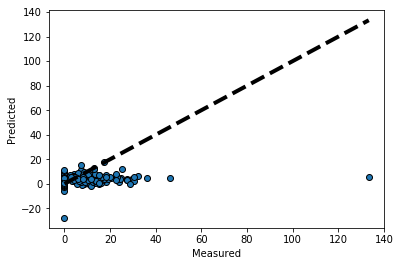

In [52]:
revenues_CL_Test = regression_Consumer_Loan.predict(X_reg_test)
fig, ax = plt.subplots()
ax.scatter(y_reg_test, revenues_CL_Test, edgecolors=(0, 0, 0))
ax.plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

[1. 1.]
[0.99360728 0.99036577]
[0.98727297 0.98082354]
[0.98099654 0.97137242]
[0.97477746 0.96201155]
[0.96861522 0.95274006]
[0.96250929 0.9435571 ]
[0.95645916 0.93446182]
[0.95046432 0.92545339]
[0.94452428 0.91653096]
[0.93863853 0.90769373]
[0.93280658 0.89894087]
[0.92702793 0.89027157]
[0.92130211 0.88168505]
[0.91562863 0.8731805 ]
[0.91000702 0.86475714]
[0.9044368 0.8564142]
[0.89891751 0.84815091]
[0.89344867 0.8399665 ]
[0.88802985 0.83186023]
[0.88266057 0.82383134]
[0.87734038 0.81587909]
[0.87206884 0.80800275]
[0.86684552 0.8002016 ]
[0.86166995 0.79247492]
[0.85654172 0.78482199]
[0.85146039 0.77724211]
[0.84642554 0.76973458]
[0.84143673 0.76229871]
[0.83649356 0.75493381]
[0.8315956  0.74763921]
[0.82674244 0.74041423]
[0.82193368 0.73325821]
[0.81716891 0.72617049]
[0.81244773 0.71915041]
[0.80776975 0.71219733]
[0.80313456 0.70531061]
[0.79854178 0.69848962]
[0.79399103 0.69173372]
[0.78948191 0.68504229]
[0.78501405 0.67841472]
[0.78058708 0.67185039]
[0.7762006

[ 0.30932445 -0.00238026]
[ 0.30926462 -0.00245738]
[ 0.30920534 -0.00253376]
[ 0.30914661 -0.00260941]
[ 0.30908842 -0.00268435]
[ 0.30903077 -0.00275858]
[ 0.30897366 -0.00283211]
[ 0.30891708 -0.00290494]
[ 0.30886102 -0.00297707]
[ 0.30880547 -0.00304852]
[ 0.30875045 -0.0031193 ]
[ 0.30869593 -0.0031894 ]
[ 0.30864192 -0.00325884]
[ 0.30858841 -0.00332762]
[ 0.30853539 -0.00339575]
[ 0.30848287 -0.00346323]
[ 0.30843083 -0.00353007]
[ 0.30837927 -0.00359628]
[ 0.3083282  -0.00366186]
[ 0.30827759 -0.00372682]
[ 0.30822745 -0.00379116]
[ 0.30817778 -0.0038549 ]
[ 0.30812857 -0.00391802]
[ 0.30807982 -0.00398055]
[ 0.30803151 -0.00404249]
[ 0.30798366 -0.00410384]
[ 0.30793624 -0.00416461]
[ 0.30788927 -0.0042248 ]
[ 0.30784273 -0.00428442]
[ 0.30779663 -0.00434347]
[ 0.30775095 -0.00440197]
[ 0.30770569 -0.00445991]
[ 0.30766085 -0.0045173 ]
[ 0.30761643 -0.00457415]
[ 0.30757242 -0.00463045]
[ 0.30752882 -0.00468623]
[ 0.30748562 -0.00474147]
[ 0.30744283 -0.00479619]
[ 0.30740043

[ 0.30292454 -0.01046098]
[ 0.30292408 -0.01046152]
[ 0.30292362 -0.01046206]
[ 0.30292317 -0.01046259]
[ 0.30292272 -0.01046312]
[ 0.30292228 -0.01046365]
[ 0.30292184 -0.01046417]
[ 0.3029214  -0.01046468]
[ 0.30292097 -0.01046519]
[ 0.30292054 -0.01046569]
[ 0.30292012 -0.01046619]
[ 0.3029197  -0.01046669]
[ 0.30291928 -0.01046718]
[ 0.30291887 -0.01046766]
[ 0.30291846 -0.01046815]
[ 0.30291806 -0.01046862]
[ 0.30291766 -0.01046909]
[ 0.30291726 -0.01046956]
[ 0.30291687 -0.01047002]
[ 0.30291648 -0.01047048]
[ 0.30291609 -0.01047094]
[ 0.30291571 -0.01047139]
[ 0.30291533 -0.01047183]
[ 0.30291496 -0.01047228]
[ 0.30291459 -0.01047271]
[ 0.30291422 -0.01047315]
[ 0.30291385 -0.01047358]
[ 0.30291349 -0.010474  ]
[ 0.30291313 -0.01047442]
[ 0.30291278 -0.01047484]
[ 0.30291243 -0.01047525]
[ 0.30291208 -0.01047566]
[ 0.30291174 -0.01047607]
[ 0.30291139 -0.01047647]
[ 0.30291106 -0.01047687]
[ 0.30291072 -0.01047726]
[ 0.30291039 -0.01047765]
[ 0.30291006 -0.01047804]
[ 0.30290973

[ 0.3028755  -0.01051825]
[ 0.3028755  -0.01051825]
[ 0.30287549 -0.01051826]
[ 0.30287549 -0.01051826]
[ 0.30287549 -0.01051826]
[ 0.30287548 -0.01051827]
[ 0.30287548 -0.01051827]
[ 0.30287548 -0.01051827]
[ 0.30287548 -0.01051828]
[ 0.30287547 -0.01051828]
[ 0.30287547 -0.01051828]
[ 0.30287547 -0.01051829]
[ 0.30287546 -0.01051829]
[ 0.30287546 -0.01051829]
[ 0.30287546 -0.0105183 ]
[ 0.30287545 -0.0105183 ]
[ 0.30287545 -0.0105183 ]
[ 0.30287545 -0.01051831]
[ 0.30287545 -0.01051831]
[ 0.30287544 -0.01051831]
[ 0.30287544 -0.01051832]
[ 0.30287544 -0.01051832]
[ 0.30287543 -0.01051832]
[ 0.30287543 -0.01051833]
[ 0.30287543 -0.01051833]
[ 0.30287543 -0.01051833]
[ 0.30287542 -0.01051833]
[ 0.30287542 -0.01051834]
[ 0.30287542 -0.01051834]
[ 0.30287542 -0.01051834]
[ 0.30287541 -0.01051835]
[ 0.30287541 -0.01051835]
[ 0.30287541 -0.01051835]
[ 0.30287541 -0.01051835]
[ 0.3028754  -0.01051836]
[ 0.3028754  -0.01051836]
[ 0.3028754  -0.01051836]
[ 0.3028754  -0.01051836]
[ 0.30287539

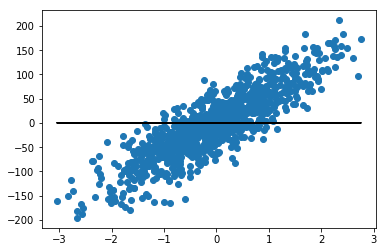

Done!


In [58]:
import numpy as np
import random
from sklearn.datasets.samples_generator import make_regression 
import pylab
from scipy import stats

def gradient_descent_2(alpha, X_reg_train, y_reg_train, numIterations):
    m = X_reg_train.shape[0] # number of samples
    theta = np.ones(2)
    print(theta)
    x_transpose = X_reg_train.transpose()
    for iter in range(0, numIterations):
        hypothesis = np.dot(X_reg_train, theta)
        loss = hypothesis - y
        J = np.sum(loss ** 2) / (2 * m)  # cost
        #print "iter %s | J: %.3f" % (iter, J)      
        gradient = np.dot(x_transpose, loss) / m         
        theta = theta - alpha * gradient  # update
    return theta

if __name__ == '__main__':

    X_reg_train, y_reg_train = make_regression(n_samples=949, n_features=1, n_informative=1, 
                        random_state=0, noise=35) 
    m, n = np.shape(X_reg_train)
    X_reg_train = np.c_[ np.ones(m), X_reg_train] # insert column
    alpha = 0.01 # learning rate
    theta = gradient_descent_2(alpha, X_reg_train, y_reg_train, 2000)
    
    # plot
    for i in range(X_reg_train.shape[1]):
        y_predict = theta[0] + theta[1]*X_reg_train
    pylab.plot(X_reg_train[:,1],y_reg_train,'o')
    pylab.plot(X_reg_train,y_predict,'k-')
    pylab.show()
    print ("Done!")

In [139]:
###############################################################################
print ("Final model optimal parameters:", regression_Consumer_Loan.best_params_)
revenues_CL_predicted = regression_Consumer_Loan.predict(prediction_classified_features)
prediction_classified_features['Predicted_CL_Revenue']=revenues_CL_predicted

Final model optimal parameters: {'copy_X': True, 'fit_intercept': False, 'normalize': True}


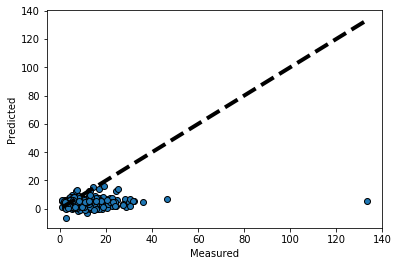

In [140]:
###############################################################################
fig, ax = plt.subplots()
ax.scatter(prediction_classified_target, revenues_CL_predicted, edgecolors=(0, 0, 0))
ax.plot([prediction_classified_target.min(), prediction_classified_target.max()], [prediction_classified_target.min(), prediction_classified_target.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [141]:
###############################################################################
prediction_classified_features.to_csv('CL_Customers.csv')

In [142]:
pwd

'C:\\Users\\DiyaMol\\KBC-Group'